In [38]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical

# Constants

In [37]:
epochs = 50
WIDTH=300
HEIGHT=300
IMAGE_SIZE=(WIDTH, HEIGHT)
IMAGE_CHANNELS=3
batch_size = 12
# Dropout rate
d = 0.3

START_EPOCH = 0.0001 

In [14]:
path = "../Tensorflow/UnSortedWaste"
filenames = os.listdir(path)

### Creating a df with path and category for each photo

In [15]:
df = pd.DataFrame({
    'filename': [],
    'category': []
})

for filename in filenames:
        category = filename[0:3]
        if category == "car":
            category1 = "cardboard"
        elif category == "gla":
            category1 = "glass"
        elif category == "met":
            category1 = "metal"
        elif category == "pap":
            category1 = "paper"
        elif category == "pla":
            category1 = "plastic"
        else:
            category1 = "other"
        
        df=df.append({'filename':path +"/"+filename, 'category': category1},ignore_index=True)


### Divide into training testing

In [29]:
df_train=df.sample(frac=0.8,replace=False)

df_valid=df.drop(df_train.index.values)

##### Sample of an image from df

cardboard185.jpg


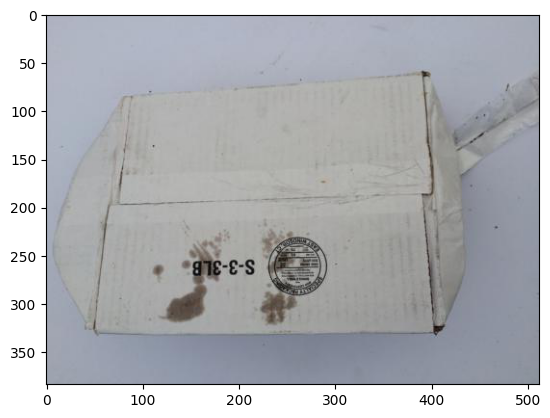

In [32]:
sample = random.choice(filenames)

image = load_img(path + "/"+sample)
plt.imshow(image)
print(sample)

paper        466
glass        409
plastic      394
metal        326
cardboard    314
other        113
Name: category, dtype: int64


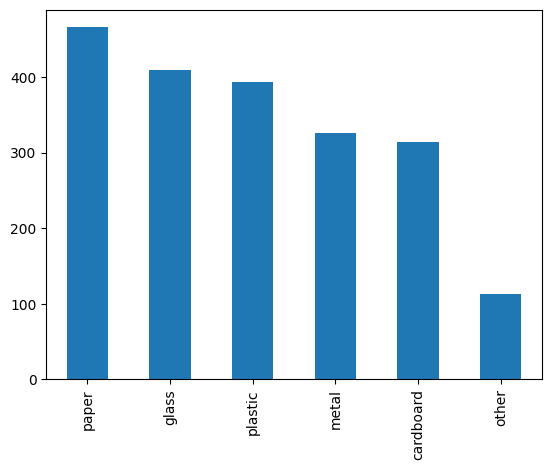

In [34]:
df_train['category'].value_counts().plot.bar()
print (df_train['category'].value_counts())

paper        128
glass         92
cardboard     89
plastic       88
metal         84
other         24
Name: category, dtype: int64


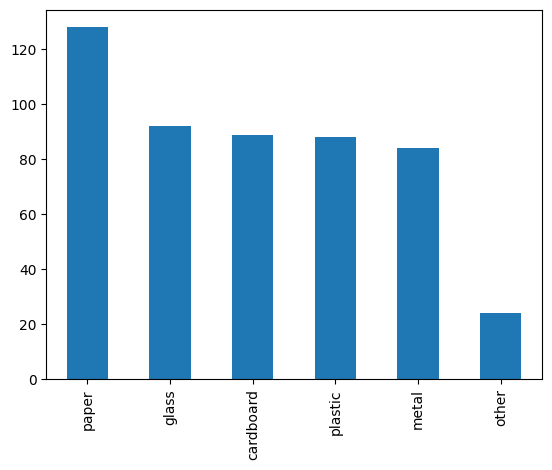

In [35]:
df_valid['category'].value_counts().plot.bar()
print (df_valid['category'].value_counts())

### Building the model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization


model = Sequential([
        #    filters, strides
        Conv2D(16, (2, 2), activation='relu', input_shape=(WIDTH, HEIGHT, IMAGE_CHANNELS)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(32, (2, 2), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (2, 2), activation='relu',padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (2, 2), activation='relu',padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
     
        Conv2D(256, (2, 2), activation='relu',padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),


        Flatten(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(d),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(d),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(d),
        Dense(6, activation='softmax')# 6 because we have 6 classes
])


model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics = ['accuracy']
)

model.summary()

### Use earlystopping to prevent overfitting

In [46]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
earlystop = EarlyStopping(patience=10,restore_best_weights=True)

### Learning rate function

In [ ]:
LR_START = 0.00005
LR_MIN = 0.000001
LR_EXP_DECAY = 0.94

def lrfn(epoch):
    lr = (LR_START - LR_MIN) * LR_EXP_DECAY**(epoch+START_EPOCH) + LR_MIN
    return lr

lr_callback = LearningRateScheduler(lrfn, verbose=True)

### Augmentation

In [50]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    df_train, 
    "", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
)


Found 2022 validated image filenames belonging to 6 classes.


In [51]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    df_valid, 
    "", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 505 validated image filenames belonging to 6 classes.


In [ ]:
history = model.fit(
    train_generator, 
    batch_size=batch_size,
    epochs=epochs,
    validation_data=validation_generator,

    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=[earlystop, lr_callback]
)

model.save_weights("model.h5")

In [21]:
test_df = df.sample(frac = 0.3)
nb_samples = test_df.shape[0]

In [22]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 758 validated image filenames.


In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [24]:
test_df['pred_category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['pred_category'] = test_df['pred_category'].replace(label_map)

In [ ]:
test_df['pred_category'].value_counts().plot.bar()

In [ ]:
import matplotlib.pyplot as plt 
import matplotlib

sample_test = test_df.sample(n=18)
plt.figure(figsize=(12, 24))

i=1
for index, row in sample_test.iterrows():
    if i <= 18:
        filename = row['filename']
        category = row['pred_category']
        img = load_img(filename, target_size=IMAGE_SIZE)
        plt.subplot(6, 3, i)
        plt.imshow(img)
        plt.title('(predicted=' + "{}".format(category) + ')')
        i+=1
plt.tight_layout()

plt.show()

In [ ]:
submission_df = test_df.copy()
submission_df.to_csv('./submission.csv', index=False)
test_df.head(30)